In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/concretecsv/concrete.csv


# Concrete Compressive Strength Prediction

This notebook explores the relationship between concrete mixture components and compressive strength using machine learning models.

The workflow includes:
- Data inspection and EDA
- Feature engineering informed by domain knowledge
- Model training, evaluation, and comparison


In [2]:
# Environment setup
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Data Loading
df = pd.read_csv("/kaggle/input/concretecsv/concrete.csv")
display(df.head())



,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [4]:
# Data Overview & Quality Check (EDA_Part 1)
df.info()
df.describe()
print("Shape:", df.shape)
print("\nDuplicates:", df.duplicated().sum())  
print("\nMissing values:\n", df.isnull().sum()) 
### Observations (Raw Data)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB
Shape: (1030, 9)

Duplicates: 25

Missing values:
 cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
strength        0
dtype: int64


### Observations (Raw Data)

- The dataset contains only numerical features with no missing values, making it suitable for tree-based models without imputation.
- Input variables represent concrete mixture components (cement, water, aggregates, additives) and curing age.
- Feature scales vary significantly (e.g., age vs aggregate quantities), which may affect linear models but is less critical for tree-based algorithms.
- The target variable (compressive strength) appears continuous and well-distributed, suitable for regression modeling.


**Feature Engineering**

In [5]:
X = df.copy()
y = X.pop("strength")
X["FCRatio"] = X["fineagg"] / X["coarseagg"]
X["AggCmtRatio"] = (X["coarseagg"] + X["fineagg"]) / X["cement"]
X["WtrCmtRatio"] = X["water"] / X["cement"]

In [6]:
X["Age_squared"] = X["age"] ** 2
X["water_FlyAsh_ratio"] = X["water"] / (X["ash"] + 1)  # +1 to avoid division by zero


Rationale:
These engineered features are motivated by concrete chemistry and material science principles, where ratios often capture strength behavior better than raw quantities.

In [7]:
# Baseline Model
baseline = RandomForestRegressor(
    criterion="absolute_error",
    random_state=0
)

baseline_score = -cross_val_score(
    baseline, X, y, cv=5,
    scoring="neg_mean_absolute_error"
).mean()

print(f"Baseline MAE: {baseline_score:.2f}")


Baseline MAE: 3.41


In [8]:
# Train Random Forest baseline:
rf = RandomForestRegressor(random_state=0)
rf_score = -1 * cross_val_score(rf, X, y, cv=5, scoring="neg_mean_absolute_error").mean()
print(f"RF Baseline MAE: {rf_score:.4f}")


RF Baseline MAE: 3.3410


In [9]:
# Advanced Model (XGBoost)
# Train XGBoost baseline:
xgb_model = xgb.XGBRegressor(random_state=0)
xgb_score = -1 * cross_val_score(xgb_model, X, y, cv=5, scoring="neg_mean_absolute_error").mean()
print(f"XGBoost Baseline MAE: {xgb_score:.4f}")


XGBoost Baseline MAE: 2.9134


Model Comparison & Conclusion
Conclusion:
XGBoost outperforms the Random Forest baseline, suggesting that boosted trees better capture nonlinear interactions among engineered concrete features.

In [10]:
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)

best_xgb = grid_search.best_estimator_
print(f"Best MAE: {-grid_search.best_score_:.4f}")


Best MAE: 2.5764


In [11]:
# Model Comparison
# Compare Random Forest vs XGBoost vs tuned XGBoost
models = [("RF", rf), ("XGB", xgb_model), ("XGB Tuned", best_xgb)]
for name, model in models:
    score = -1 * cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error").mean()
    print(f"{name} MAE: {score:.4f}")


RF MAE: 3.3410
XGB MAE: 2.9134
XGB Tuned MAE: 2.5764


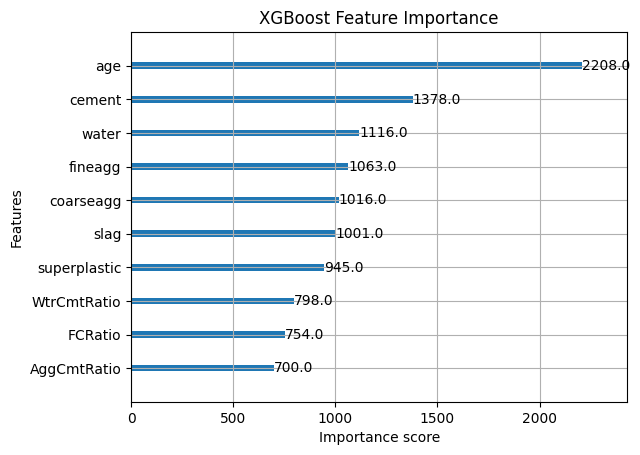

In [12]:
# Target Variable Exploration (EDA – Part 2)
# Plot feature importance (for tuned XGBoost):

xgb.plot_importance(best_xgb, max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.show()


Observation:
The target shows moderate skewness and variability, suggesting that MAE is an appropriate evaluation metric.

In [13]:
# Evaluation & Interpretation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
# rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse =np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")


Test MAE: 2.4539
Test RMSE: 4.0002


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0 )

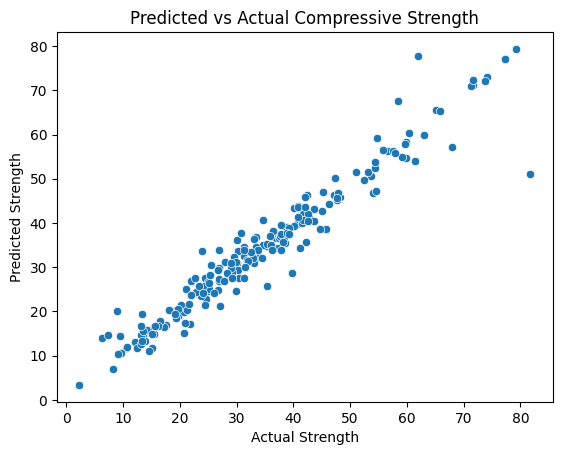

In [15]:
# Visualization & Storytelling

sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Strength")
plt.ylabel("Predicted Strength")
plt.title("Predicted vs Actual Compressive Strength")
plt.show()

### Observations (Engineered Features & Relationships)

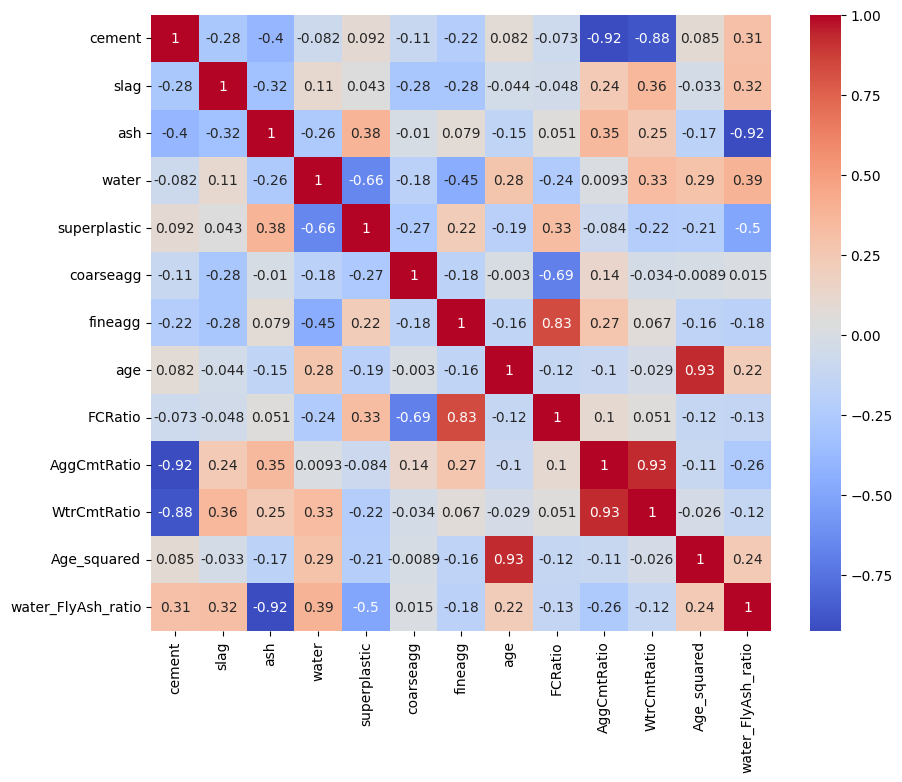

In [16]:
# Feature correlation heatmap:
plt.figure(figsize=(10,8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.show()
### Observations (Engineered Features & Relationships)

Narrative text: explain:

Why certain ratios (Water/Cement, Aggregate ratios) matter

How MAE translates to practical impact on concrete quality

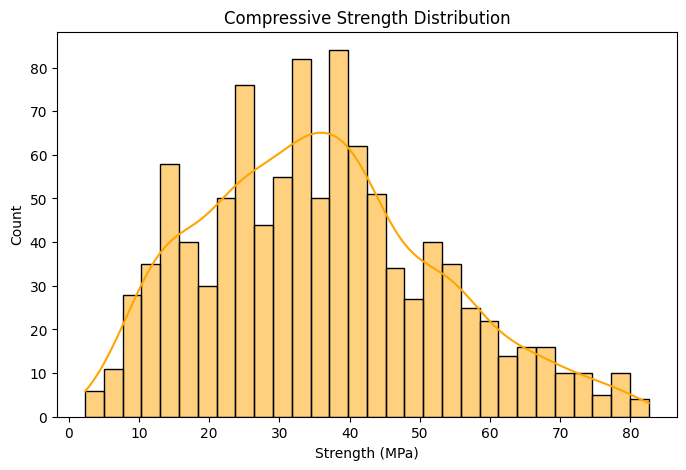

In [17]:
plt.figure(figsize=(8,5))
sns.histplot(y, kde=True, bins=30, color='orange')
plt.title("Compressive Strength Distribution")
plt.xlabel("Strength (MPa)")
plt.ylabel("Count")
plt.show()
### Observations (Engineered Features & Relationships)


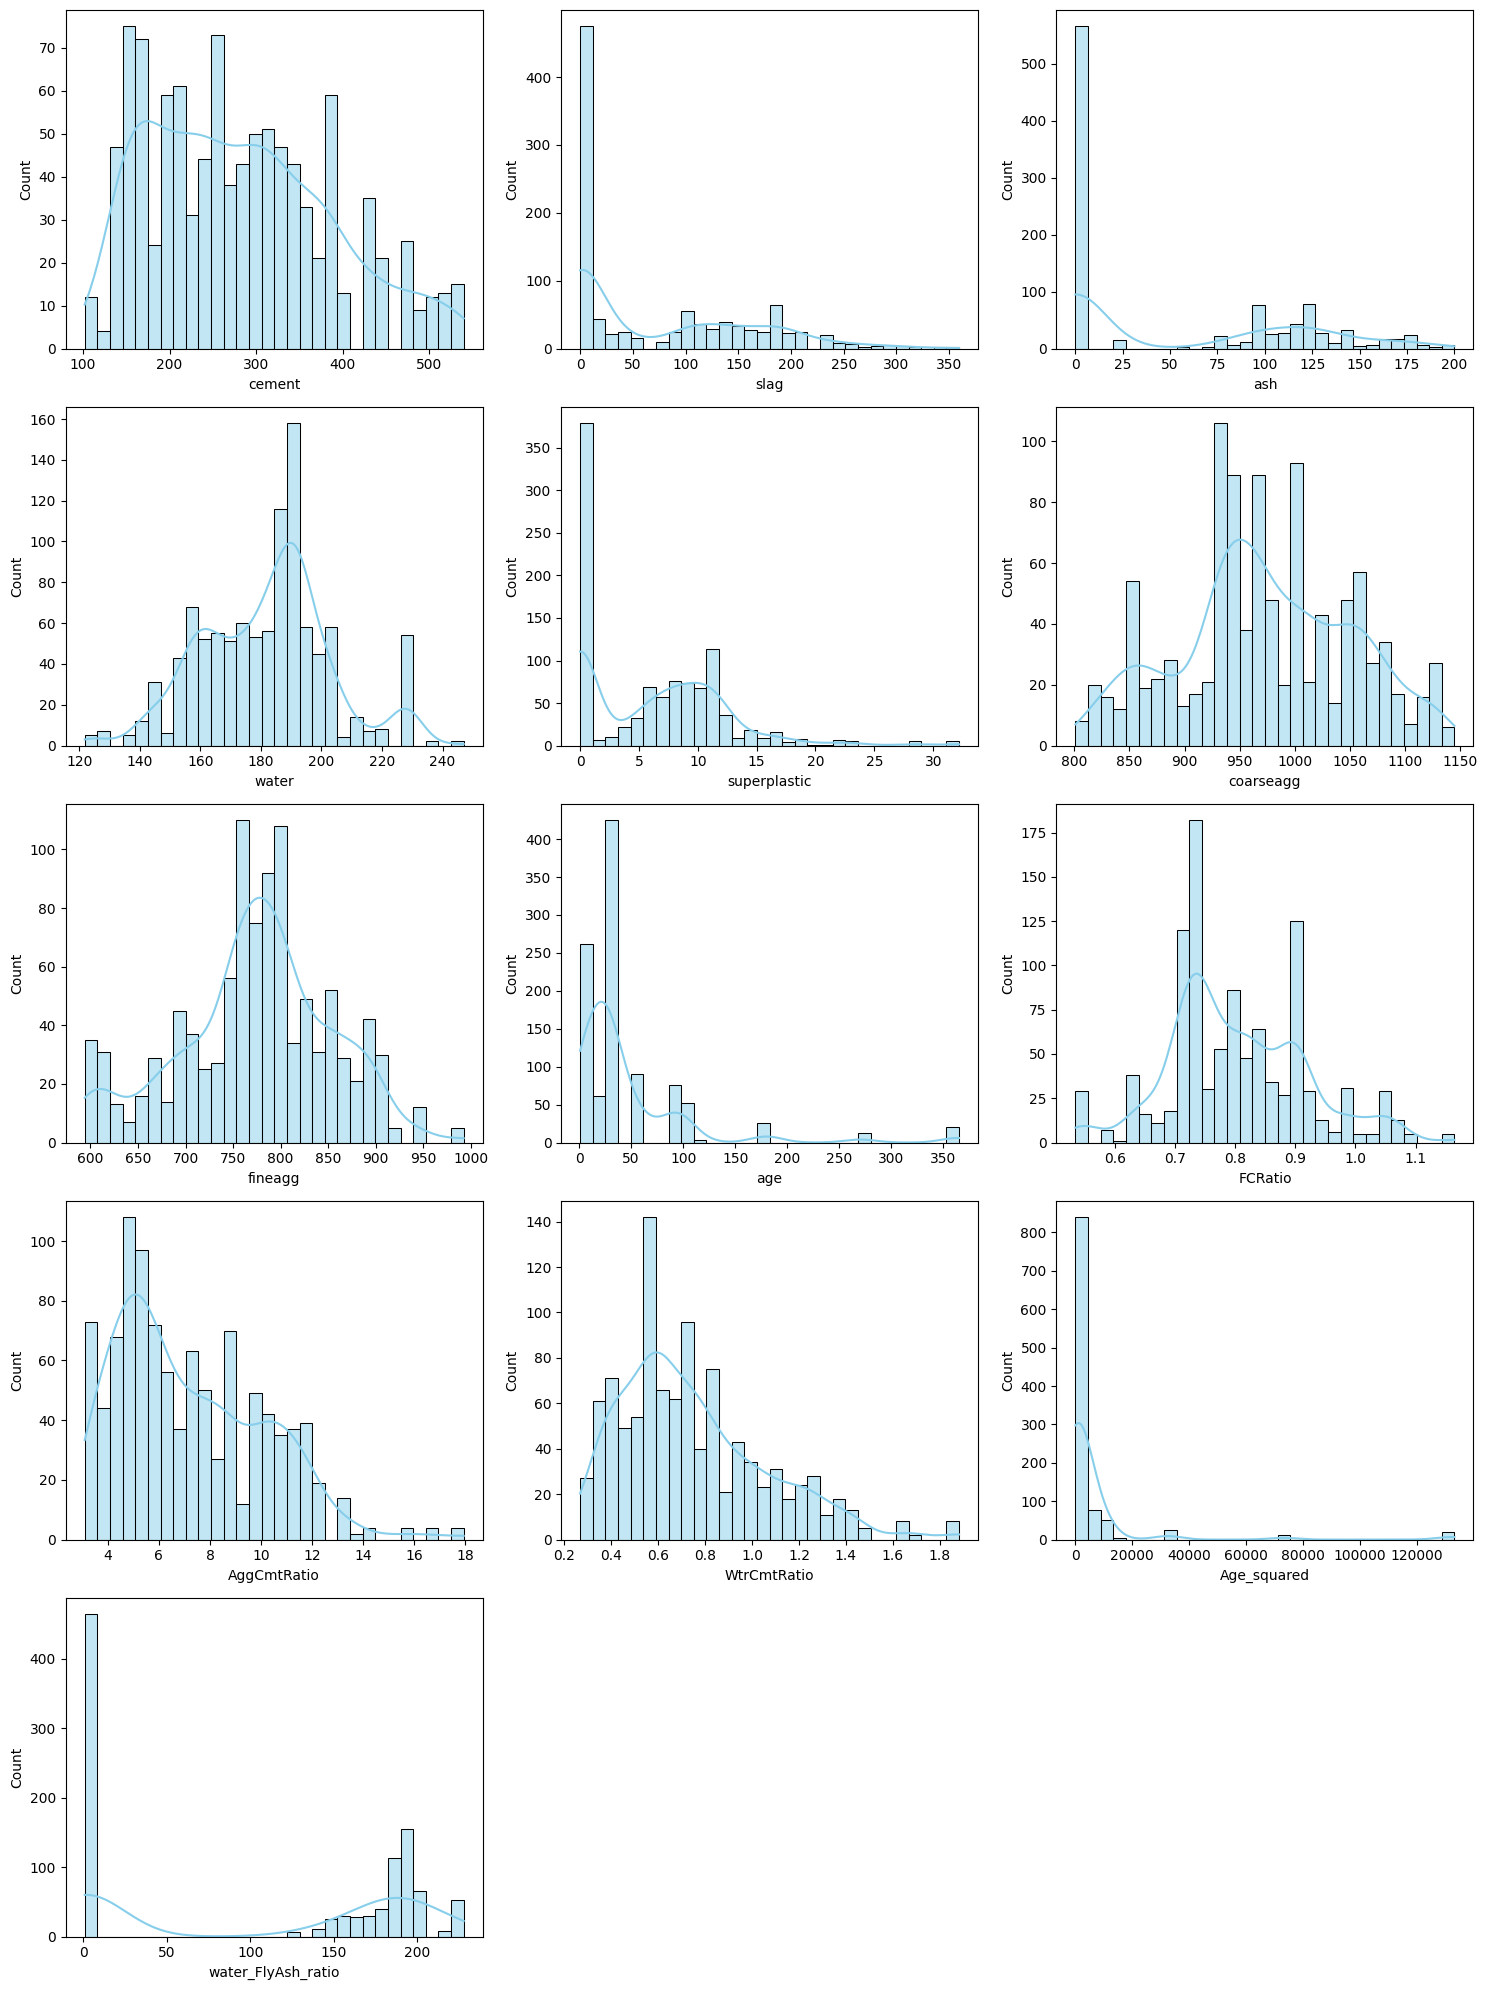

In [18]:
# Feature Distribution Analysis (EDA – Part 3)
import math

numeric_features = X.select_dtypes(include=[np.number]).columns

# Set number of columns
n_cols = 3  # can adjust to fit screen
n_rows = math.ceil(len(numeric_features) / n_cols)

plt.figure(figsize=(n_cols*5, n_rows*4))

for i, col in enumerate(numeric_features):
    plt.subplot(n_rows, n_cols, i+1)
    sns.histplot(X[col], kde=True, bins=30, color='skyblue')

plt.tight_layout()
plt.show()
### Observations (Engineered Features & Relationships)

Observation:
Engineered ratio features show clearer distributions and reduced skew compared to raw material quantities.

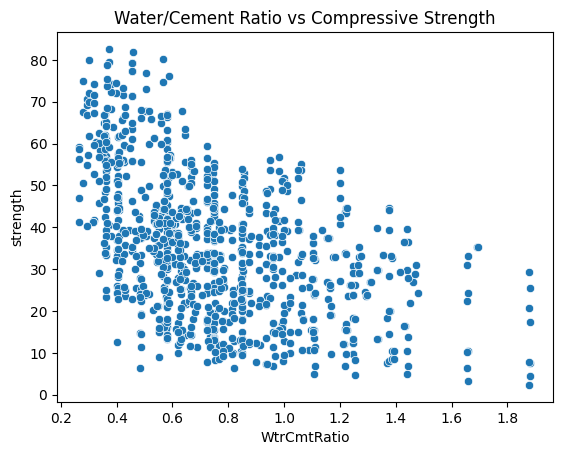

In [19]:
# highlight engineered features:
sns.scatterplot(x=X["WtrCmtRatio"], y=y)
plt.title("Water/Cement Ratio vs Compressive Strength")
plt.show()

### Observations (Engineered Features & Relationships)

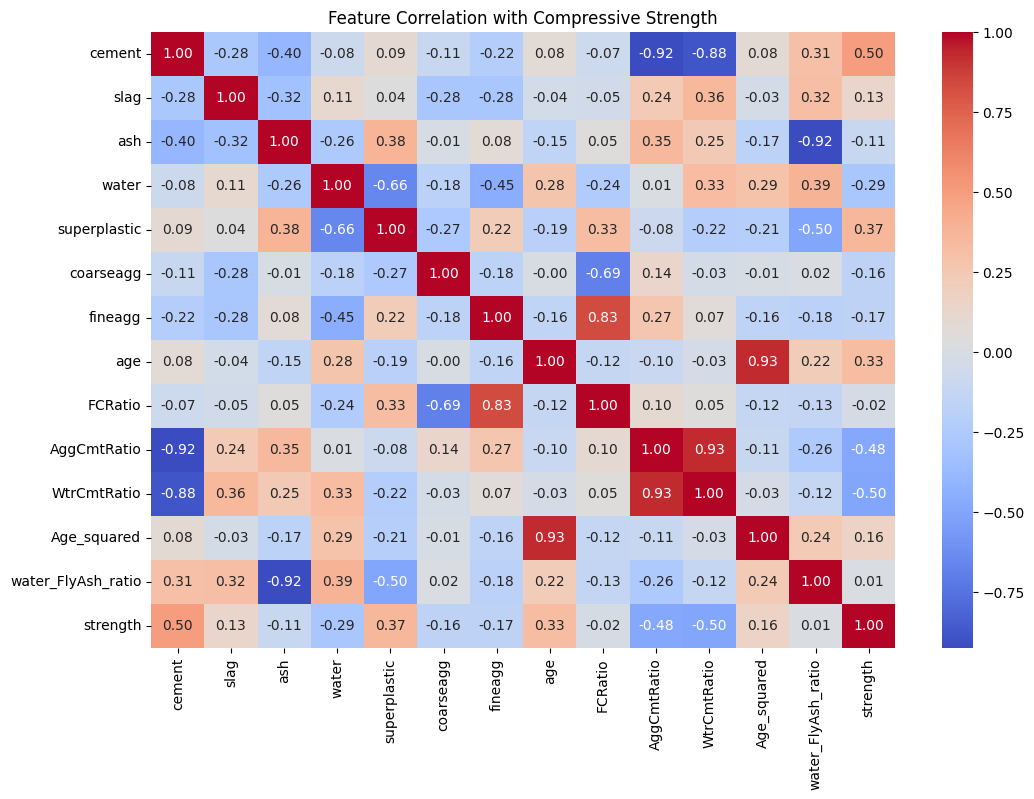

In [20]:
# Correlation Heatmap

# Shows which features are most correlated with strength:

plt.figure(figsize=(12,8))
sns.heatmap(X.join(y).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation with Compressive Strength")
plt.show()

### Observations (Engineered Features & Relationships)

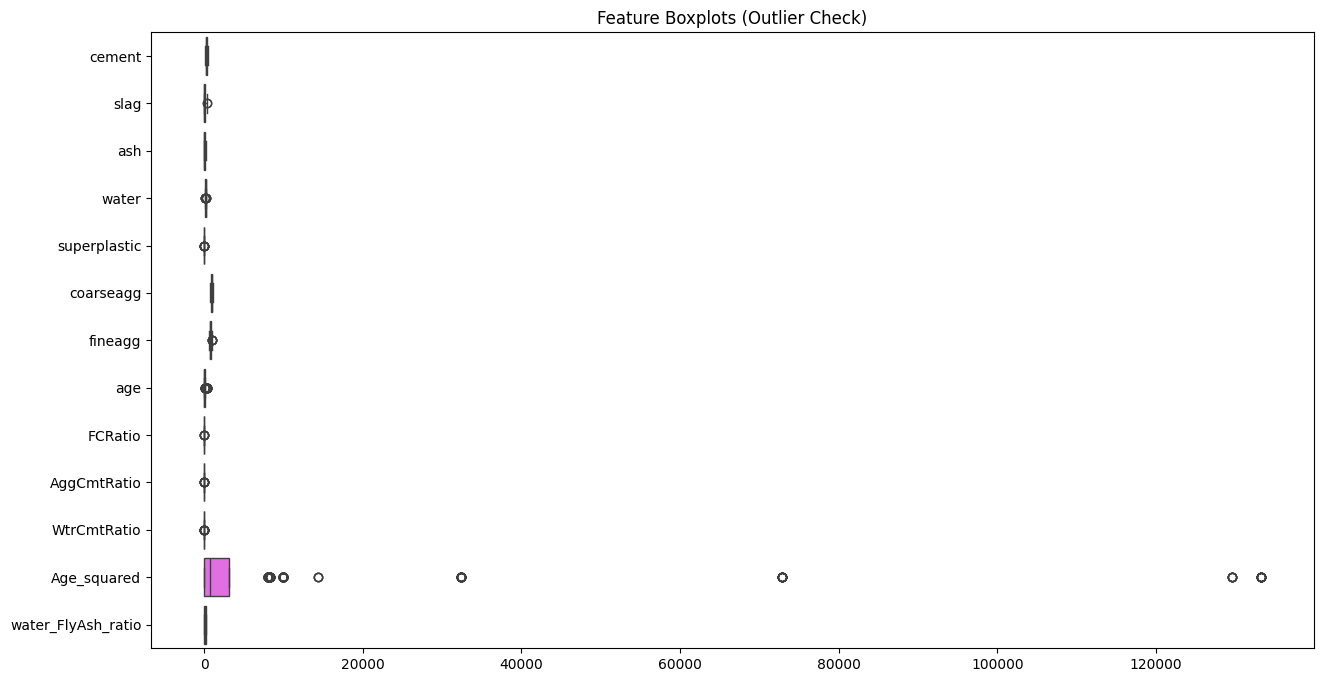

In [21]:
# Boxplots for Outlier Detection
plt.figure(figsize=(15,8))
sns.boxplot(data=X[numeric_features], orient='h')
plt.title("Feature Boxplots (Outlier Check)")
plt.show()

### Observations (Engineered Features & Relationships)

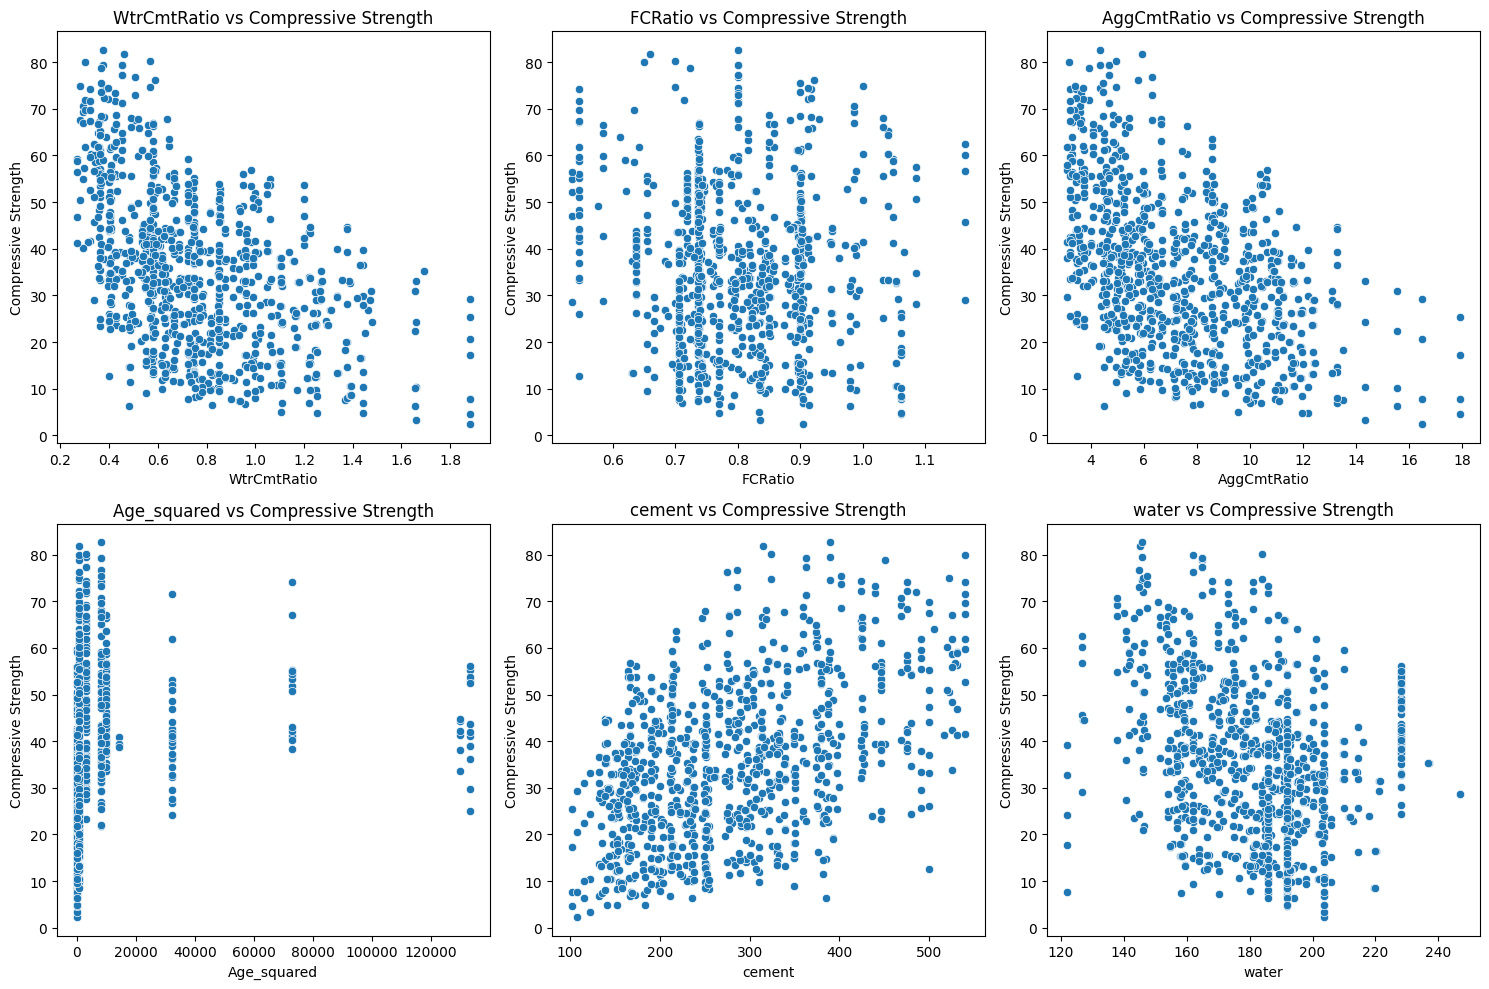

In [22]:
# Feature vs Target Relationships (EDA – Part 4)
# Pairplot
# Shows relationships between features and target:

key_features = ["WtrCmtRatio", "FCRatio", "AggCmtRatio", "Age_squared", "cement", "water"]

plt.figure(figsize=(15,10))
for i, col in enumerate(key_features):
    plt.subplot(2, 3, i+1)
    sns.scatterplot(x=X[col], y=y)
    plt.xlabel(col)
    plt.ylabel("Compressive Strength")
    plt.title(f"{col} vs Compressive Strength")
plt.tight_layout()
plt.show()

### Observations (Engineered Features & Relationships)

### Observations (Engineered Features & Relationships)

- The Water-to-Cement ratio shows a strong inverse relationship with compressive strength, aligning with concrete engineering principles.
- Cement content and curing age demonstrate positive correlations with strength, highlighting their dominant influence.
- Engineered ratio features (e.g., Water/Cement, Aggregate/Cement) provide clearer relationships with strength than raw material quantities.
- Outlier presence in some aggregate-related features suggests natural variability rather than data quality issues.
- Correlation analysis indicates limited multicollinearity concerns for tree-based models, supporting the use of ensemble methods.


These insights motivated the inclusion of ratio-based features and the selection of tree-based ensemble models.
